### Model Training Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
cd ..

c:\Users\Matheus\Documents\Git\knowledge-graph-completion


#### Bart Example

In [3]:
# from transformers import BartForConditionalGeneration, BartTokenizer

# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0)
# tok = BartTokenizer.from_pretrained("facebook/bart-large")

In [4]:
# example_english_phrase = "Dominican Republic has form of government of <mask>"
# batch = tok(example_english_phrase, return_tensors="pt")
# generated_ids = model.generate(batch["input_ids"])
# tok.batch_decode(generated_ids, skip_special_tokens=True)

### Load data

In [5]:
import pandas as pd
from src.utils import load_fb15k237

PATH_FB15k237 = "data/datasets_knowledge_embedding/FB15k-237"

train, valid, test, entity2wikidata = load_fb15k237(PATH_FB15k237)
processed_data = pd.read_csv(PATH_FB15k237 + "/processed_data.csv")

### Load the model

In [6]:
from transformers import (
    BartForConditionalGeneration,
    BartTokenizer,
    BartConfig,
    DataCollatorForSeq2Seq,
)

MAX_LENGHT = 512
MODEL = "facebook/bart-base"

tok = BartTokenizer.from_pretrained("facebook/bart-large")

### Some tests

In [7]:
sample = processed_data.iloc[5]

In [8]:
text_sample = sample.demonstration_input + sample.tail_text + "."
text_sample

'Sunderland A.F.C. has position of defender. A.S. Roma has position of forward. Maldives national football teamhas position of forward.'

In [9]:
to_mask = sample.tail_text
to_mask

'forward'

In [10]:
ids_to_mask = tok.convert_tokens_to_ids(to_mask)
print(ids_to_mask)
print(tok.convert_ids_to_tokens(ids_to_mask))

16135
forward


In [11]:
print(
    tok.encode(
        "i want to mask Hello world",
        add_special_tokens=True,
        max_length=MAX_LENGHT,
        truncation=True,
        padding="max_length",
    )[:10]
)

print(
    tok.encode(
        "i want to mask <mask>",
        add_special_tokens=True,
        max_length=MAX_LENGHT,
        truncation=True,
        padding="max_length",
    )[:10]
)

[0, 118, 236, 7, 11445, 20920, 232, 2, 1, 1]
[0, 118, 236, 7, 11445, 50264, 2, 1, 1, 1]


In [12]:
print(tok.all_special_tokens)
print(tok.all_special_ids)

['<s>', '</s>', '<unk>', '<pad>', '<mask>']
[0, 2, 3, 1, 50264]


In [13]:
tok.mask_token_id

50264

### Masking data

In [14]:
processed_data["data_input"] = processed_data["demonstration_input"] + "<mask>."
processed_data["data_label"] = (
    processed_data["demonstration_input"] + processed_data["tail_text"] + "."
)

In [15]:
# pd.set_option("display.max_colwidth", None)

# processed_data[["data_input", "data_label"]].head()

In [16]:
# tok.convert_ids_to_tokens(tok.encode(processed_data["data_input"].iloc[0]))

In [17]:
# Debug
processed_data_dev = processed_data.head(10000)

In [18]:
from transformers import DataCollatorForLanguageModeling

# Codifica as strings de entrada e rótulos como sequências de tokens BART
encoded_input = tok(
    list(processed_data_dev["data_input"]),
    padding=True,
    truncation=True,
    return_tensors="pt",
)
encoded_label = tok(
    list(processed_data_dev["data_label"]),
    padding=True,
    truncation=True,
    return_tensors="pt",
)

# Cria uma lista de exemplos
examples = []
for i in range(len(processed_data_dev)):
    input_ids = encoded_input["input_ids"][i]
    attention_mask = encoded_input["attention_mask"][i]
    labels = encoded_label["input_ids"][i]
    examples.append(
        {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}
    )

# Cria um objeto DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tok, mlm=False)

# Prepara os dados de treinamento
prepared_data = data_collator(examples)

In [19]:
# list(
#     filter(
#         lambda i: i != "<pad>", tok.convert_ids_to_tokens(prepared_data["input_ids"][0])
#     )
# )

In [20]:
# prepared_data.items()

### Training Model

In [21]:
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
from torch.utils.data import Dataset
import copy
import random


class DatasetKGC(Dataset):
    def __init__(self, data):
        self.data = data
        self.data["input_ids"] = self.data["input_ids"].to(device)
        self.data["labels"] = self.data["input_ids"].to(device)
        self.num_rows = len(data)

    def __len__(self):
        return self.num_rows

    def __getitem__(self, idx):
        _input = self.data["input_ids"][idx].squeeze(0)
        label = self.data["labels"][idx].squeeze(0)
        # attention_mask = self.data["attention_mask"].squeeze(0)

        return (_input, label)

In [23]:
import os

batch_size = 8
data_loader = DataLoader(DatasetKGC(prepared_data), batch_size=batch_size, shuffle=True)

In [24]:
# model = BartForConditionalGeneration.from_pretrained("lucadiliello/bart-small").to(
#     device
# )

model = BartForConditionalGeneration.from_pretrained(MODEL).to(device)

In [25]:
# Setup
epochs = 15
loss_epoch = []
lr = 1e-3
cross = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    epoch_loss = 0
    print("Epoch %d" % epoch)
    for _input, label in data_loader:
        model.zero_grad()
        _dt = model(_input, return_dict=True)
        logits = _dt.logits
        loss = cross(logits.view(-1, logits.size(-1)), label.view(-1))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    torch.cuda.empty_cache()
    loss_epoch.append(epoch_loss)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14


In [26]:
torch.cuda.empty_cache()

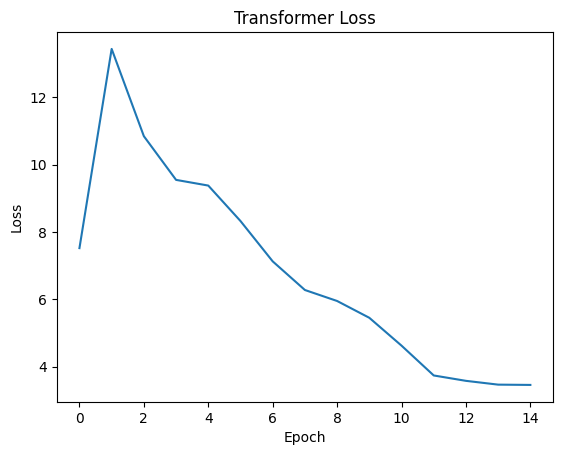

In [27]:
import matplotlib.pyplot as plt

plt.title("Transformer Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_epoch)

In [28]:
loss_epoch

[7.521730422973633,
 13.440181732177734,
 10.847399711608887,
 9.549077987670898,
 9.380145072937012,
 8.326635360717773,
 7.128264427185059,
 6.277518272399902,
 5.950900077819824,
 5.4516282081604,
 4.624149322509766,
 3.7382192611694336,
 3.578526735305786,
 3.4656214714050293,
 3.4571926593780518]